In [7]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models
from torchvision.models import DenseNet201_Weights, EfficientNet_B4_Weights

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score



In [8]:
# Dataset Path
dataset_path = '/kaggle/input/different-skin-diseases-dataset/Skin_Diseases_Dataset2'

train_dir = '/kaggle/input/different-skin-diseases-dataset/Skin_Diseases_Dataset2/train'
test_dir = '/kaggle/input/different-skin-diseases-dataset/Skin_Diseases_Dataset2/val'

train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'val')

# Data Transforms
train_transforms = transforms.Compose([
    transforms.Resize((380, 380)),  # Input size for EfficientNet and DenseNet
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((380, 380)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
# Load Dataset
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

# Handle Class Imbalance
class_counts = [0] * len(train_dataset.classes)
for _, label in train_dataset:
    class_counts[label] += 1

class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
sample_weights = [class_weights[label] for _, label in train_dataset]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print("✅ Classes:", train_dataset.classes)


✅ Classes: ['Actinic keratosis', 'Atopic Dermatitis', 'Benign keratosis', 'Dermatofibroma', 'Melanocytic nevus', 'Melanoma', 'Squamous cell carcinoma', 'Tinea Ringworm Candidiasis', 'Vascular lesion']


In [10]:
# Channel Attention (Squeeze-and-Excitation Block)
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


In [11]:
# OmniNet Classifier
class OmniNet(nn.Module):
    def __init__(self, num_classes=9):
        super(OmniNet, self).__init__()
        # EfficientNet-B4 Backbone
        self.efficientnet = models.efficientnet_b4(weights=EfficientNet_B4_Weights.DEFAULT)
        self.densenet = models.densenet201(weights=DenseNet201_Weights.DEFAULT)
        
        # Freeze the feature extractors
        for param in self.efficientnet.parameters():
            param.requires_grad = False
        for param in self.densenet.parameters():
            param.requires_grad = False
        
        # Attention Mechanism
        self.se_block = SEBlock(1792)  # For EfficientNet-B4
        
        # Global Average Pooling Layers
        self.efficientnet_gap = nn.AdaptiveAvgPool2d(1)  # GAP for EfficientNet
        self.densenet_gap = nn.AdaptiveAvgPool2d(1)      # GAP for DenseNet
        
        # Fully Connected Layers
        self.fc = nn.Sequential(
            nn.Linear(1792 + 1920, 1024),  # Concatenated features
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        # EfficientNet-B4 features
        x1 = self.efficientnet.features(x)  # (Batch x 1792 x 12 x 12)
        x1 = self.se_block(x1)
        x1 = self.efficientnet_gap(x1)  # (Batch x 1792 x 1 x 1)
        x1 = torch.flatten(x1, 1)  # (Batch x 1792)
        
        # DenseNet-201 features
        x2 = self.densenet.features(x)  # (Batch x 1920 x 7 x 7)
        x2 = self.densenet_gap(x2)  # (Batch x 1920 x 1 x 1)
        x2 = torch.flatten(x2, 1)  # (Batch x 1920)
        
        # Concatenate features
        x = torch.cat((x1, x2), dim=1)  # (Batch x (1792 + 1920))
        
        # Fully Connected Layers
        x = self.fc(x)
        return x


In [12]:
# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using Device:", device)

model = OmniNet(num_classes=9).to(device)

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4, weight_decay=1e-4)

# Print Constant Learning Rate
print(f"✅ Constant Learning Rate: {optimizer.param_groups[0]['lr']}")


✅ Using Device: cuda
✅ Constant Learning Rate: 0.0001


In [13]:
# Training Loop
num_epochs = 50
train_losses, val_losses = [], []
train_accs, val_accs = [], []

best_val_acc = 0.0
best_model = copy.deepcopy(model.state_dict())

print("🚀 Starting Training...")

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient Clipping
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_acc = 100.0 * correct / total
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)
    
    # Validation Phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    epoch_val_loss = val_running_loss / len(test_dataset)
    epoch_val_acc = 100.0 * val_correct / val_total
    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)
    
    elapsed_time = time.time() - start_time
    print(f"Epoch {epoch+1}/{num_epochs} | 🕒 {elapsed_time:.2f}s | "
          f"📉 Train Loss: {epoch_train_loss:.4f} | 📈 Train Acc: {epoch_train_acc:.2f}% | "
          f"📉 Val Loss: {epoch_val_loss:.4f} | 📈 Val Acc: {epoch_val_acc:.2f}% | "
          f"⚙️ LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        best_model = copy.deepcopy(model.state_dict())

# Load Best Model
model.load_state_dict(best_model)
print(f"✅ Training Complete! Best Validation Accuracy: {best_val_acc:.2f}%")


🚀 Starting Training...


Epoch 1/50: 100%|██████████| 44/44 [00:12<00:00,  3.60it/s]


Epoch 1/50 | 🕒 15.44s | 📉 Train Loss: 1.8585 | 📈 Train Acc: 35.29% | 📉 Val Loss: 1.4224 | 📈 Val Acc: 66.30% | ⚙️ LR: 0.000100


Epoch 2/50: 100%|██████████| 44/44 [00:12<00:00,  3.60it/s]


Epoch 2/50 | 🕒 15.10s | 📉 Train Loss: 1.2843 | 📈 Train Acc: 62.55% | 📉 Val Loss: 1.0068 | 📈 Val Acc: 68.51% | ⚙️ LR: 0.000100


Epoch 3/50: 100%|██████████| 44/44 [00:12<00:00,  3.54it/s]


Epoch 3/50 | 🕒 15.32s | 📉 Train Loss: 1.0105 | 📈 Train Acc: 70.16% | 📉 Val Loss: 0.8251 | 📈 Val Acc: 73.48% | ⚙️ LR: 0.000100


Epoch 4/50: 100%|██████████| 44/44 [00:12<00:00,  3.52it/s]


Epoch 4/50 | 🕒 15.36s | 📉 Train Loss: 0.8820 | 📈 Train Acc: 72.45% | 📉 Val Loss: 0.7465 | 📈 Val Acc: 75.14% | ⚙️ LR: 0.000100


Epoch 5/50: 100%|██████████| 44/44 [00:12<00:00,  3.55it/s]


Epoch 5/50 | 🕒 15.30s | 📉 Train Loss: 0.7870 | 📈 Train Acc: 76.18% | 📉 Val Loss: 0.6921 | 📈 Val Acc: 76.24% | ⚙️ LR: 0.000100


Epoch 6/50: 100%|██████████| 44/44 [00:12<00:00,  3.59it/s]


Epoch 6/50 | 🕒 15.13s | 📉 Train Loss: 0.7127 | 📈 Train Acc: 77.33% | 📉 Val Loss: 0.6519 | 📈 Val Acc: 76.80% | ⚙️ LR: 0.000100


Epoch 7/50: 100%|██████████| 44/44 [00:12<00:00,  3.61it/s]


Epoch 7/50 | 🕒 15.07s | 📉 Train Loss: 0.6249 | 📈 Train Acc: 81.78% | 📉 Val Loss: 0.5954 | 📈 Val Acc: 78.45% | ⚙️ LR: 0.000100


Epoch 8/50: 100%|██████████| 44/44 [00:11<00:00,  3.78it/s]


Epoch 8/50 | 🕒 14.52s | 📉 Train Loss: 0.5803 | 📈 Train Acc: 82.50% | 📉 Val Loss: 0.5951 | 📈 Val Acc: 77.35% | ⚙️ LR: 0.000100


Epoch 9/50: 100%|██████████| 44/44 [00:12<00:00,  3.51it/s]


Epoch 9/50 | 🕒 15.44s | 📉 Train Loss: 0.5500 | 📈 Train Acc: 86.08% | 📉 Val Loss: 0.5698 | 📈 Val Acc: 79.56% | ⚙️ LR: 0.000100


Epoch 10/50: 100%|██████████| 44/44 [00:11<00:00,  3.68it/s]


Epoch 10/50 | 🕒 14.83s | 📉 Train Loss: 0.5532 | 📈 Train Acc: 82.50% | 📉 Val Loss: 0.5555 | 📈 Val Acc: 81.22% | ⚙️ LR: 0.000100


Epoch 11/50: 100%|██████████| 44/44 [00:12<00:00,  3.53it/s]


Epoch 11/50 | 🕒 15.33s | 📉 Train Loss: 0.5133 | 📈 Train Acc: 83.07% | 📉 Val Loss: 0.5148 | 📈 Val Acc: 83.43% | ⚙️ LR: 0.000100


Epoch 12/50: 100%|██████████| 44/44 [00:11<00:00,  3.68it/s]


Epoch 12/50 | 🕒 14.84s | 📉 Train Loss: 0.4789 | 📈 Train Acc: 85.65% | 📉 Val Loss: 0.5128 | 📈 Val Acc: 82.32% | ⚙️ LR: 0.000100


Epoch 13/50: 100%|██████████| 44/44 [00:12<00:00,  3.58it/s]


Epoch 13/50 | 🕒 15.16s | 📉 Train Loss: 0.4760 | 📈 Train Acc: 84.65% | 📉 Val Loss: 0.4904 | 📈 Val Acc: 85.64% | ⚙️ LR: 0.000100


Epoch 14/50: 100%|██████████| 44/44 [00:11<00:00,  3.70it/s]


Epoch 14/50 | 🕒 14.78s | 📉 Train Loss: 0.4341 | 📈 Train Acc: 86.51% | 📉 Val Loss: 0.4639 | 📈 Val Acc: 85.64% | ⚙️ LR: 0.000100


Epoch 15/50: 100%|██████████| 44/44 [00:11<00:00,  3.67it/s]


Epoch 15/50 | 🕒 14.96s | 📉 Train Loss: 0.4012 | 📈 Train Acc: 87.66% | 📉 Val Loss: 0.4648 | 📈 Val Acc: 84.53% | ⚙️ LR: 0.000100


Epoch 16/50: 100%|██████████| 44/44 [00:12<00:00,  3.55it/s]


Epoch 16/50 | 🕒 15.30s | 📉 Train Loss: 0.4121 | 📈 Train Acc: 86.80% | 📉 Val Loss: 0.4625 | 📈 Val Acc: 83.43% | ⚙️ LR: 0.000100


Epoch 17/50: 100%|██████████| 44/44 [00:12<00:00,  3.56it/s]


Epoch 17/50 | 🕒 15.29s | 📉 Train Loss: 0.3796 | 📈 Train Acc: 88.81% | 📉 Val Loss: 0.4801 | 📈 Val Acc: 82.32% | ⚙️ LR: 0.000100


Epoch 18/50: 100%|██████████| 44/44 [00:12<00:00,  3.46it/s]


Epoch 18/50 | 🕒 15.58s | 📉 Train Loss: 0.3533 | 📈 Train Acc: 89.10% | 📉 Val Loss: 0.5133 | 📈 Val Acc: 80.11% | ⚙️ LR: 0.000100


Epoch 19/50: 100%|██████████| 44/44 [00:12<00:00,  3.65it/s]


Epoch 19/50 | 🕒 14.96s | 📉 Train Loss: 0.3576 | 📈 Train Acc: 88.09% | 📉 Val Loss: 0.4448 | 📈 Val Acc: 82.32% | ⚙️ LR: 0.000100


Epoch 20/50: 100%|██████████| 44/44 [00:12<00:00,  3.57it/s]


Epoch 20/50 | 🕒 15.22s | 📉 Train Loss: 0.3338 | 📈 Train Acc: 88.81% | 📉 Val Loss: 0.4653 | 📈 Val Acc: 79.56% | ⚙️ LR: 0.000100


Epoch 21/50: 100%|██████████| 44/44 [00:12<00:00,  3.61it/s]


Epoch 21/50 | 🕒 15.07s | 📉 Train Loss: 0.3357 | 📈 Train Acc: 89.24% | 📉 Val Loss: 0.4487 | 📈 Val Acc: 83.43% | ⚙️ LR: 0.000100


Epoch 22/50: 100%|██████████| 44/44 [00:12<00:00,  3.62it/s]


Epoch 22/50 | 🕒 15.04s | 📉 Train Loss: 0.3331 | 📈 Train Acc: 88.81% | 📉 Val Loss: 0.4076 | 📈 Val Acc: 85.64% | ⚙️ LR: 0.000100


Epoch 23/50: 100%|██████████| 44/44 [00:12<00:00,  3.61it/s]


Epoch 23/50 | 🕒 15.09s | 📉 Train Loss: 0.3282 | 📈 Train Acc: 89.10% | 📉 Val Loss: 0.4357 | 📈 Val Acc: 83.98% | ⚙️ LR: 0.000100


Epoch 24/50: 100%|██████████| 44/44 [00:12<00:00,  3.65it/s]


Epoch 24/50 | 🕒 14.94s | 📉 Train Loss: 0.2796 | 📈 Train Acc: 90.53% | 📉 Val Loss: 0.4250 | 📈 Val Acc: 83.98% | ⚙️ LR: 0.000100


Epoch 25/50: 100%|██████████| 44/44 [00:12<00:00,  3.56it/s]


Epoch 25/50 | 🕒 15.28s | 📉 Train Loss: 0.3142 | 📈 Train Acc: 89.67% | 📉 Val Loss: 0.4255 | 📈 Val Acc: 85.08% | ⚙️ LR: 0.000100


Epoch 26/50: 100%|██████████| 44/44 [00:12<00:00,  3.62it/s]


Epoch 26/50 | 🕒 15.03s | 📉 Train Loss: 0.2674 | 📈 Train Acc: 92.25% | 📉 Val Loss: 0.4608 | 📈 Val Acc: 82.87% | ⚙️ LR: 0.000100


Epoch 27/50: 100%|██████████| 44/44 [00:12<00:00,  3.67it/s]


Epoch 27/50 | 🕒 14.89s | 📉 Train Loss: 0.2784 | 📈 Train Acc: 91.25% | 📉 Val Loss: 0.4427 | 📈 Val Acc: 82.87% | ⚙️ LR: 0.000100


Epoch 28/50: 100%|██████████| 44/44 [00:12<00:00,  3.49it/s]


Epoch 28/50 | 🕒 15.50s | 📉 Train Loss: 0.2730 | 📈 Train Acc: 90.10% | 📉 Val Loss: 0.4439 | 📈 Val Acc: 85.64% | ⚙️ LR: 0.000100


Epoch 29/50: 100%|██████████| 44/44 [00:12<00:00,  3.62it/s]


Epoch 29/50 | 🕒 15.05s | 📉 Train Loss: 0.2943 | 📈 Train Acc: 89.81% | 📉 Val Loss: 0.4586 | 📈 Val Acc: 85.64% | ⚙️ LR: 0.000100


Epoch 30/50: 100%|██████████| 44/44 [00:12<00:00,  3.63it/s]


Epoch 30/50 | 🕒 15.02s | 📉 Train Loss: 0.2707 | 📈 Train Acc: 91.54% | 📉 Val Loss: 0.4449 | 📈 Val Acc: 85.64% | ⚙️ LR: 0.000100


Epoch 31/50: 100%|██████████| 44/44 [00:12<00:00,  3.63it/s]


Epoch 31/50 | 🕒 15.04s | 📉 Train Loss: 0.2631 | 📈 Train Acc: 91.68% | 📉 Val Loss: 0.4310 | 📈 Val Acc: 85.64% | ⚙️ LR: 0.000100


Epoch 32/50: 100%|██████████| 44/44 [00:12<00:00,  3.63it/s]


Epoch 32/50 | 🕒 14.97s | 📉 Train Loss: 0.2581 | 📈 Train Acc: 91.82% | 📉 Val Loss: 0.4340 | 📈 Val Acc: 83.43% | ⚙️ LR: 0.000100


Epoch 33/50: 100%|██████████| 44/44 [00:12<00:00,  3.66it/s]


Epoch 33/50 | 🕒 14.90s | 📉 Train Loss: 0.2190 | 📈 Train Acc: 92.40% | 📉 Val Loss: 0.4351 | 📈 Val Acc: 84.53% | ⚙️ LR: 0.000100


Epoch 34/50: 100%|██████████| 44/44 [00:12<00:00,  3.63it/s]


Epoch 34/50 | 🕒 15.10s | 📉 Train Loss: 0.2085 | 📈 Train Acc: 93.54% | 📉 Val Loss: 0.4503 | 📈 Val Acc: 83.98% | ⚙️ LR: 0.000100


Epoch 35/50: 100%|██████████| 44/44 [00:11<00:00,  3.71it/s]


Epoch 35/50 | 🕒 14.72s | 📉 Train Loss: 0.2907 | 📈 Train Acc: 89.96% | 📉 Val Loss: 0.4227 | 📈 Val Acc: 85.08% | ⚙️ LR: 0.000100


Epoch 36/50: 100%|██████████| 44/44 [00:12<00:00,  3.64it/s]


Epoch 36/50 | 🕒 14.98s | 📉 Train Loss: 0.1941 | 📈 Train Acc: 94.40% | 📉 Val Loss: 0.4502 | 📈 Val Acc: 86.19% | ⚙️ LR: 0.000100


Epoch 37/50: 100%|██████████| 44/44 [00:12<00:00,  3.54it/s]


Epoch 37/50 | 🕒 15.31s | 📉 Train Loss: 0.2140 | 📈 Train Acc: 92.40% | 📉 Val Loss: 0.4870 | 📈 Val Acc: 82.32% | ⚙️ LR: 0.000100


Epoch 38/50: 100%|██████████| 44/44 [00:11<00:00,  3.69it/s]


Epoch 38/50 | 🕒 14.82s | 📉 Train Loss: 0.2305 | 📈 Train Acc: 91.97% | 📉 Val Loss: 0.4954 | 📈 Val Acc: 80.66% | ⚙️ LR: 0.000100


Epoch 39/50: 100%|██████████| 44/44 [00:12<00:00,  3.57it/s]


Epoch 39/50 | 🕒 15.19s | 📉 Train Loss: 0.1985 | 📈 Train Acc: 93.69% | 📉 Val Loss: 0.4774 | 📈 Val Acc: 82.87% | ⚙️ LR: 0.000100


Epoch 40/50: 100%|██████████| 44/44 [00:12<00:00,  3.63it/s]


Epoch 40/50 | 🕒 14.99s | 📉 Train Loss: 0.2278 | 📈 Train Acc: 93.54% | 📉 Val Loss: 0.4852 | 📈 Val Acc: 83.98% | ⚙️ LR: 0.000100


Epoch 41/50: 100%|██████████| 44/44 [00:12<00:00,  3.51it/s]


Epoch 41/50 | 🕒 15.39s | 📉 Train Loss: 0.1982 | 📈 Train Acc: 93.97% | 📉 Val Loss: 0.5205 | 📈 Val Acc: 82.87% | ⚙️ LR: 0.000100


Epoch 42/50: 100%|██████████| 44/44 [00:12<00:00,  3.61it/s]


Epoch 42/50 | 🕒 15.06s | 📉 Train Loss: 0.2075 | 📈 Train Acc: 93.40% | 📉 Val Loss: 0.4949 | 📈 Val Acc: 81.22% | ⚙️ LR: 0.000100


Epoch 43/50: 100%|██████████| 44/44 [00:12<00:00,  3.57it/s]


Epoch 43/50 | 🕒 15.24s | 📉 Train Loss: 0.1837 | 📈 Train Acc: 94.55% | 📉 Val Loss: 0.5064 | 📈 Val Acc: 83.43% | ⚙️ LR: 0.000100


Epoch 44/50: 100%|██████████| 44/44 [00:12<00:00,  3.58it/s]


Epoch 44/50 | 🕒 15.18s | 📉 Train Loss: 0.2023 | 📈 Train Acc: 93.54% | 📉 Val Loss: 0.5096 | 📈 Val Acc: 82.87% | ⚙️ LR: 0.000100


Epoch 45/50: 100%|██████████| 44/44 [00:13<00:00,  3.37it/s]


Epoch 45/50 | 🕒 15.97s | 📉 Train Loss: 0.2270 | 📈 Train Acc: 92.68% | 📉 Val Loss: 0.4770 | 📈 Val Acc: 82.87% | ⚙️ LR: 0.000100


Epoch 46/50: 100%|██████████| 44/44 [00:12<00:00,  3.58it/s]


Epoch 46/50 | 🕒 15.18s | 📉 Train Loss: 0.1919 | 📈 Train Acc: 94.12% | 📉 Val Loss: 0.5116 | 📈 Val Acc: 83.43% | ⚙️ LR: 0.000100


Epoch 47/50: 100%|██████████| 44/44 [00:12<00:00,  3.50it/s]


Epoch 47/50 | 🕒 15.45s | 📉 Train Loss: 0.1685 | 📈 Train Acc: 94.84% | 📉 Val Loss: 0.5022 | 📈 Val Acc: 81.22% | ⚙️ LR: 0.000100


Epoch 48/50: 100%|██████████| 44/44 [00:12<00:00,  3.66it/s]


Epoch 48/50 | 🕒 14.88s | 📉 Train Loss: 0.1775 | 📈 Train Acc: 94.55% | 📉 Val Loss: 0.5369 | 📈 Val Acc: 79.56% | ⚙️ LR: 0.000100


Epoch 49/50: 100%|██████████| 44/44 [00:12<00:00,  3.42it/s]


Epoch 49/50 | 🕒 15.73s | 📉 Train Loss: 0.2237 | 📈 Train Acc: 92.83% | 📉 Val Loss: 0.5178 | 📈 Val Acc: 82.32% | ⚙️ LR: 0.000100


Epoch 50/50: 100%|██████████| 44/44 [00:11<00:00,  3.72it/s]


Epoch 50/50 | 🕒 14.70s | 📉 Train Loss: 0.1901 | 📈 Train Acc: 92.40% | 📉 Val Loss: 0.4884 | 📈 Val Acc: 81.77% | ⚙️ LR: 0.000100
✅ Training Complete! Best Validation Accuracy: 86.19%


In [14]:
# Save the Best Model
model_save_path = '/kaggle/working/OmniNetSkinClassifier_Best.pth'
torch.save(model.state_dict(), model_save_path)
print(f"✅ Model Saved at {model_save_path}!")


✅ Model Saved at /kaggle/working/OmniNetSkinClassifier_Best.pth!


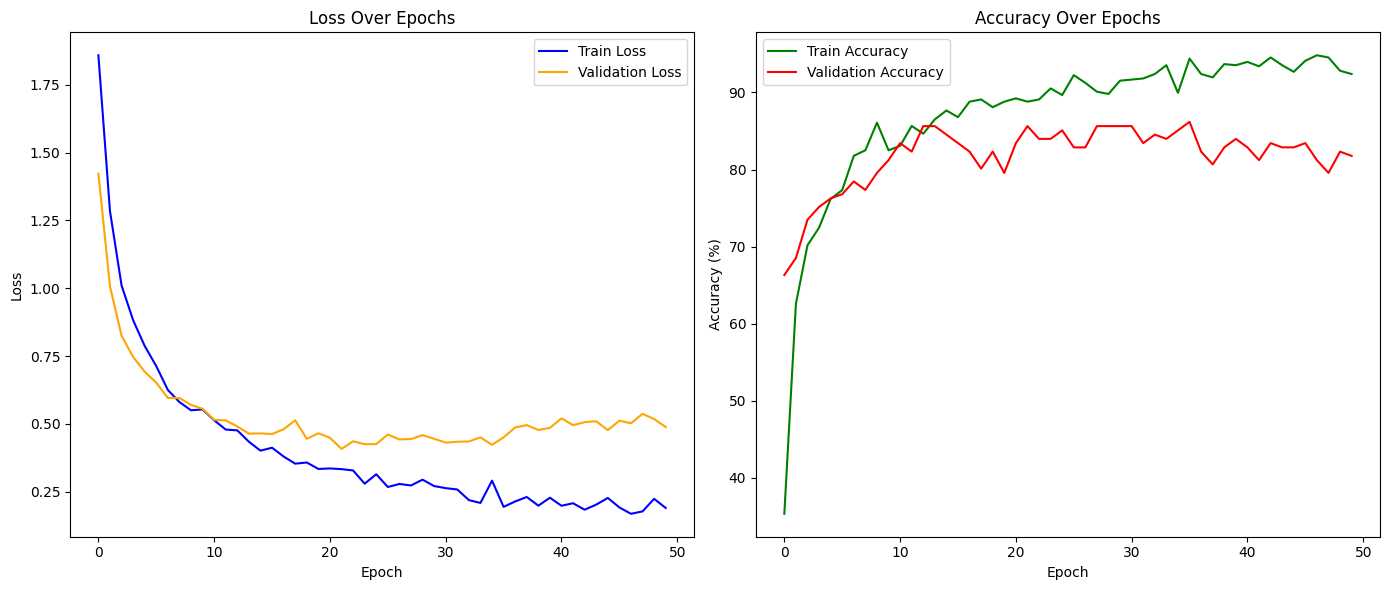

In [15]:
# Plot Metrics
plt.figure(figsize=(14, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy', color='green')
plt.plot(val_accs, label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [16]:
# ✅ Evaluation on Test Dataset

# Switch to evaluation mode
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating on Test Dataset"):
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


Evaluating on Test Dataset: 100%|██████████| 12/12 [00:02<00:00,  4.20it/s]


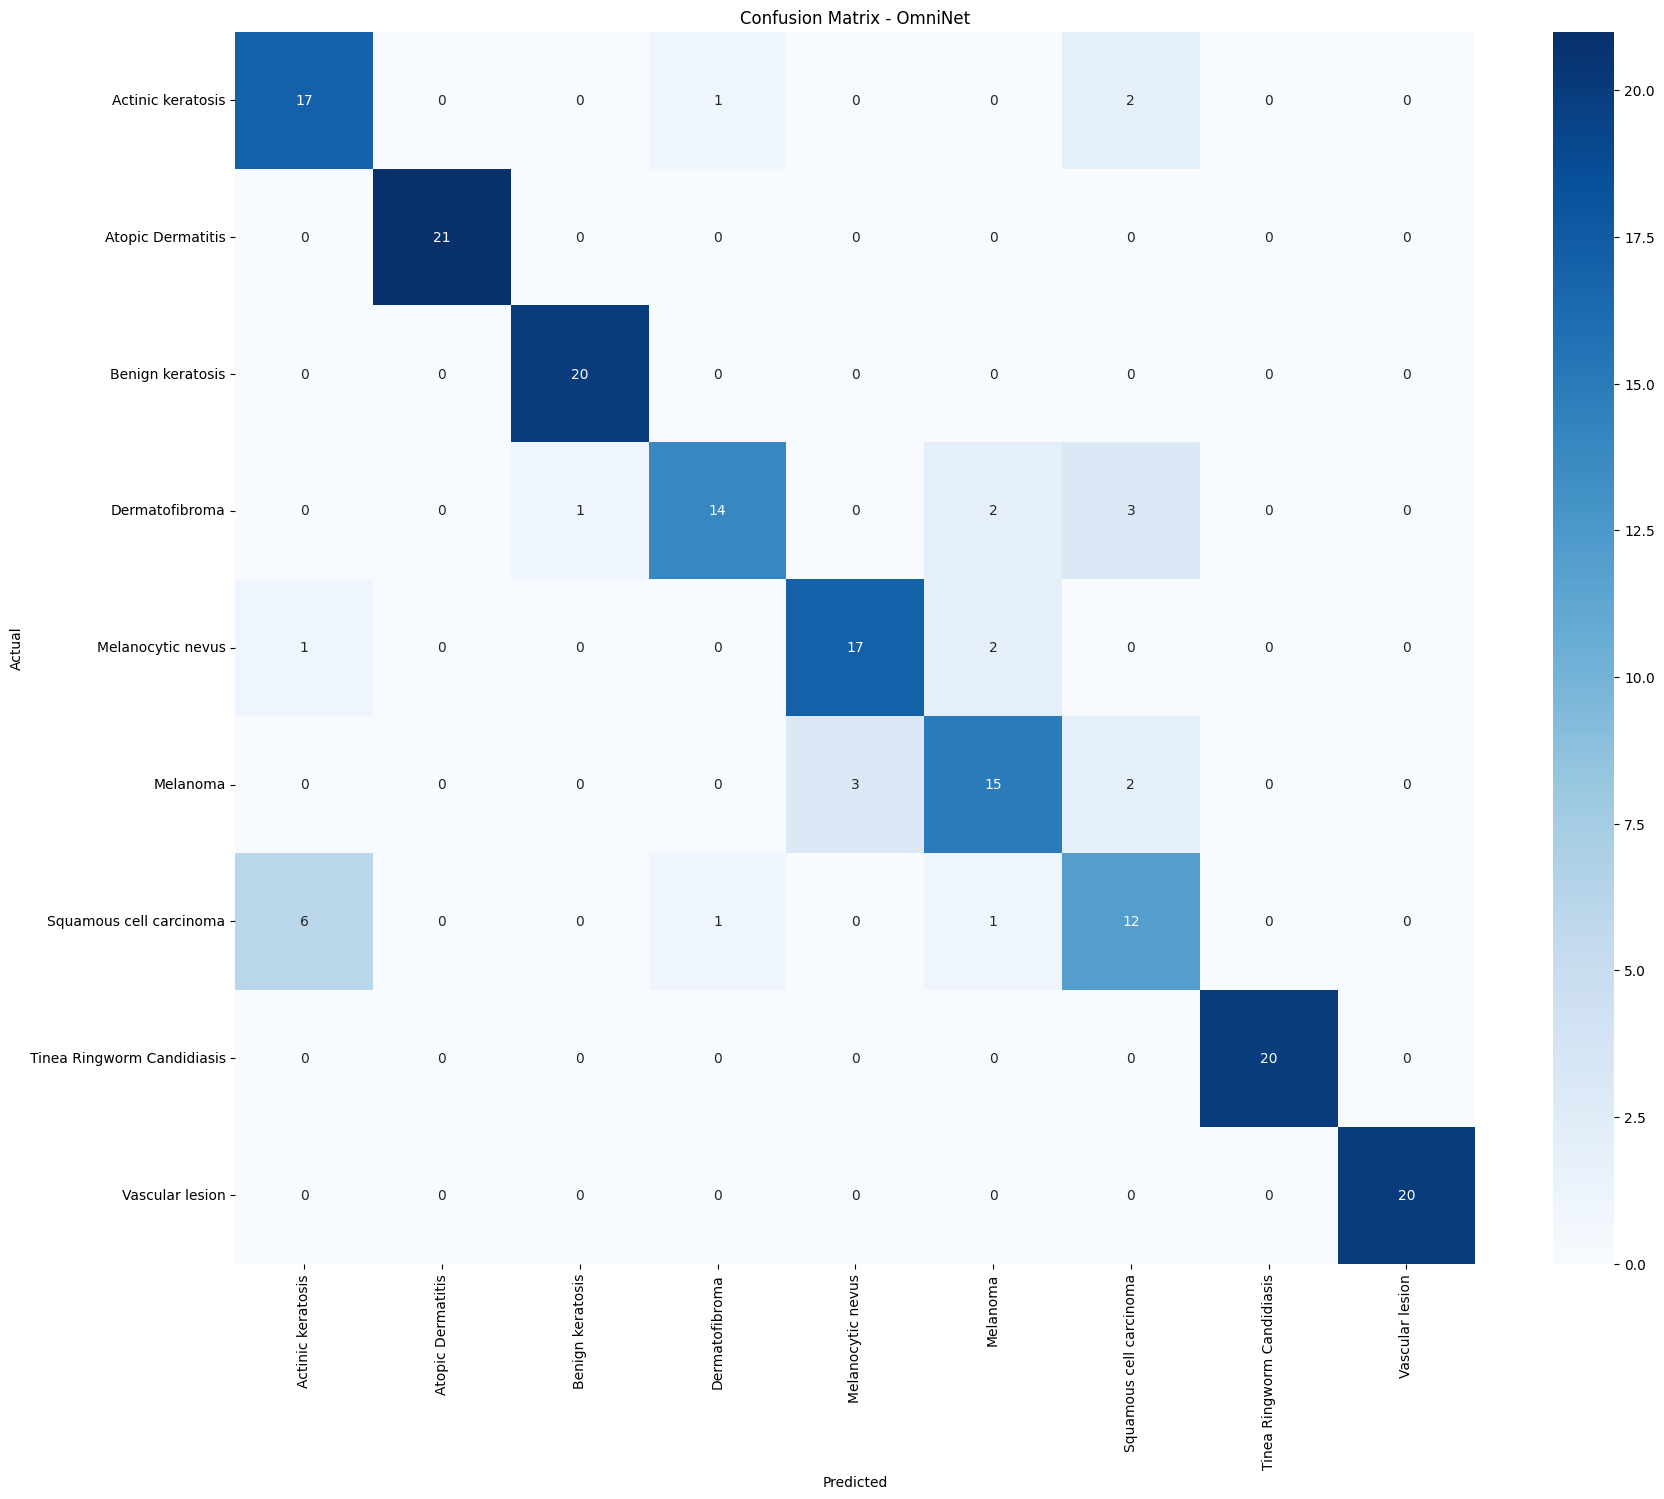

Classification Report:

                            precision    recall  f1-score   support

         Actinic keratosis       0.71      0.85      0.77        20
         Atopic Dermatitis       1.00      1.00      1.00        21
          Benign keratosis       0.95      1.00      0.98        20
            Dermatofibroma       0.88      0.70      0.78        20
         Melanocytic nevus       0.85      0.85      0.85        20
                  Melanoma       0.75      0.75      0.75        20
   Squamous cell carcinoma       0.63      0.60      0.62        20
Tinea Ringworm Candidiasis       1.00      1.00      1.00        20
           Vascular lesion       1.00      1.00      1.00        20

                  accuracy                           0.86       181
                 macro avg       0.86      0.86      0.86       181
              weighted avg       0.86      0.86      0.86       181



In [17]:
# ✅ Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(20, 16))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_dataset.classes, 
            yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - OmniNet')
plt.show()

# ✅ Classification Report
report = classification_report(all_labels, all_preds, target_names=train_dataset.classes)
print("Classification Report:\n")
print(report)


✅ Class Names Aligned Successfully: ['Actinic keratosis', 'Atopic Dermatitis', 'Benign keratosis', 'Dermatofibroma', 'Melanocytic nevus', 'Melanoma', 'Squamous cell carcinoma', 'Tinea Ringworm Candidiasis', 'Vascular lesion']


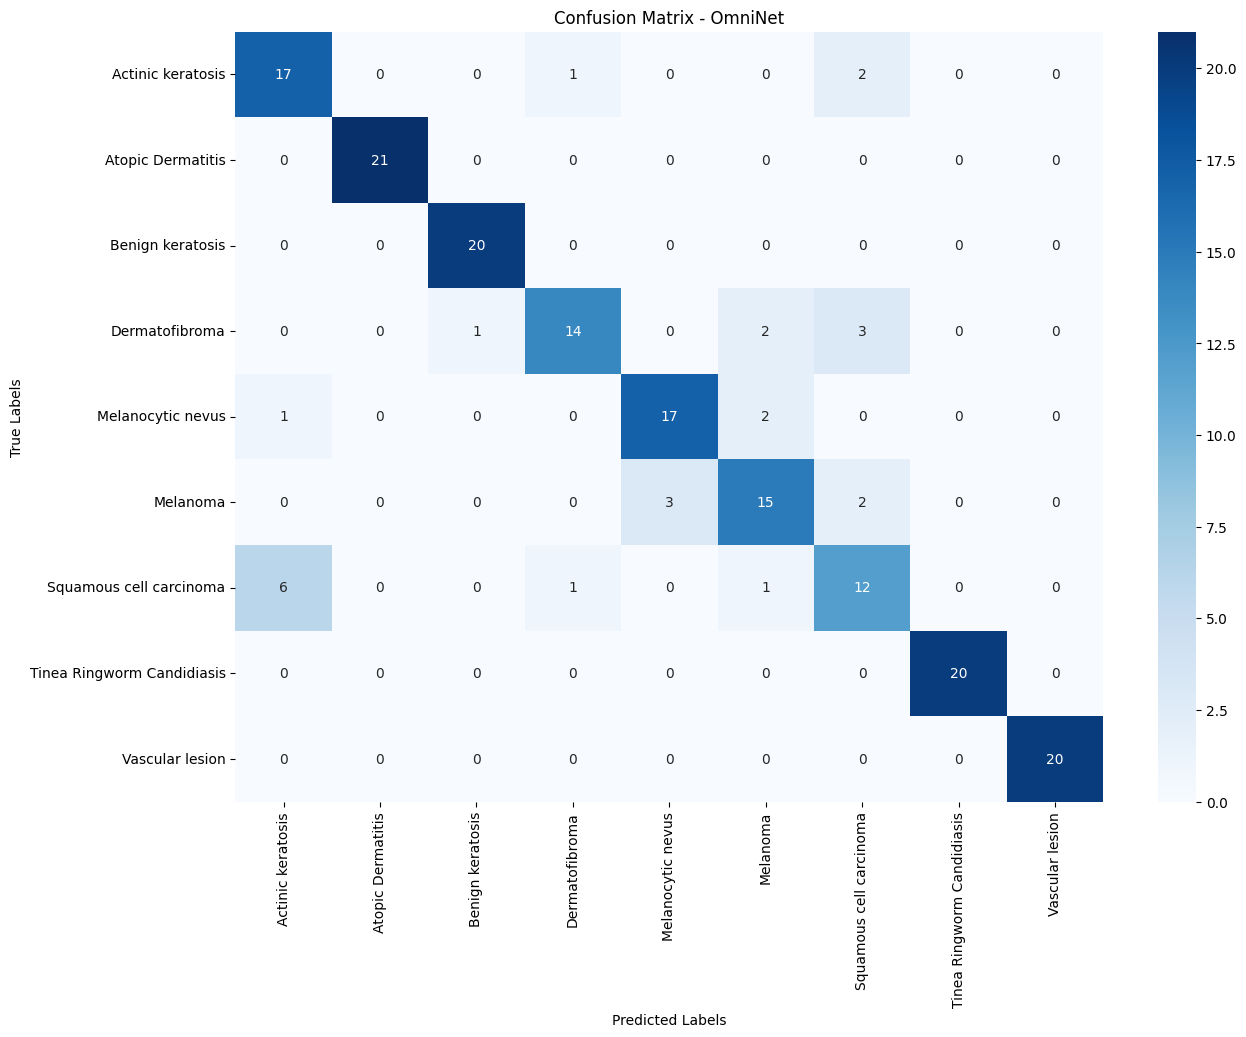

✅ Classification Report:
                            precision    recall  f1-score   support

         Actinic keratosis       0.71      0.85      0.77        20
         Atopic Dermatitis       1.00      1.00      1.00        21
          Benign keratosis       0.95      1.00      0.98        20
            Dermatofibroma       0.88      0.70      0.78        20
         Melanocytic nevus       0.85      0.85      0.85        20
                  Melanoma       0.75      0.75      0.75        20
   Squamous cell carcinoma       0.63      0.60      0.62        20
Tinea Ringworm Candidiasis       1.00      1.00      1.00        20
           Vascular lesion       1.00      1.00      1.00        20

                  accuracy                           0.86       181
                 macro avg       0.86      0.86      0.86       181
              weighted avg       0.86      0.86      0.86       181


✅ Overall Metrics:
🔹 Accuracy: 0.8619
🔹 Error Rate: 0.1381
🔹 Precision (Macro Avg): 0.8

In [18]:
# Additional Metrics Calculation

# Class Names
class_names = train_dataset.classes
print("✅ Class Names Aligned Successfully:", class_names)

# Confusion Matrix for Additional Metrics
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(class_names))))
plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix - OmniNet')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
print("✅ Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

# Overall Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
error_rate = 1 - accuracy

# Specificity Calculation
def calculate_specificity_per_class(cm):
    specificity_per_class = []
    num_classes = cm.shape[0]
    
    for i in range(num_classes):
        TP = cm[i, i]
        FP = np.sum(cm[:, i]) - TP
        FN = np.sum(cm[i, :]) - TP
        TN = np.sum(cm) - (TP + FP + FN)
        
        specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
        specificity_per_class.append(specificity)
    
    specificity_avg = np.mean(specificity_per_class)
    return specificity_avg, specificity_per_class

specificity_avg, specificity_per_class = calculate_specificity_per_class(cm)

# Print Overall Metrics
print("\n✅ Overall Metrics:")
print(f"🔹 Accuracy: {accuracy:.4f}")
print(f"🔹 Error Rate: {error_rate:.4f}")
print(f"🔹 Precision (Macro Avg): {precision:.4f}")
print(f"🔹 Recall (Macro Avg): {recall:.4f}")
print(f"🔹 F1-Score (Macro Avg): {f1:.4f}")
print(f"🔹 Specificity (Macro Avg): {specificity_avg:.4f}")

# Print Class-wise Specificity
print("\n✅ Specificity per Class:")
for i, spec in enumerate(specificity_per_class):
    print(f"🔹 {class_names[i]}: {spec:.4f}")


In [19]:
# Direct Evaluation after Loading
# If you need to load the model later, use the following code:

# model = OmniNet(num_classes=9)
# model.load_state_dict(torch.load('/kaggle/working/OmniNetSkinClassifier_Best.pth'))
# model.to(device)
# model.eval()

# # Perform evaluation as done previously
# all_preds = []
# all_labels = []

# with torch.no_grad():
#     for images, labels in test_loader:
#         images, labels = images.to(device), labels.to(device)
#         outputs = model(images)
#         _, preds = torch.max(outputs, 1)
#         all_preds.extend(preds.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())

# # Proceed with metrics calculation as in previous cells
